In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

We will be running 4 models: 1) KNN, 2) Random Forest, 3) Logistic Regression and 4) Nueral Network. First we will introduce our data.

In [2]:
heart = pd.read_csv("heart.csv")
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Now we will describe each variable. 

age: in years

sex: 0 - Female, 1 - Male

cp: types of chest pain. 0 - Typical Angina, 1 - Atypical Angina, 2 - non-anginal pain, 3 - Asymptomatic 

trtbps: resting systolic blood pressure(mm Hg). Measures the pressure in you arteries when your heart beats.

chol: serum cholesterol (HDL, LDL and triglycerides) (mg/dl)

fbs: fasting blood sugar (1 if >= 120 mg/dl, 0 otherwise)

restecg: resting electrocardiographic results: 0 - normal, 1 - ST-T wave abnormality, 2 - showing probablie or definite left ventricular hypertrophy.

thalachh: maximum heart rate achieved during strenuous exercise

exng: exercise induced heart pain: 1 - yes, 0 - no

oldpeak: ST depression induced from exercise

slp: slope of the peak exercise segment ST wave segment

caa: coronary arteries with an abnormality(0-4)

thall: Thallium stress test to check blood flow.


In [4]:
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Get dummie variables for categorical data.

In [5]:
cp = pd.get_dummies(heart["cp"])
cp = cp.rename({0:"TA", 1:"ATA", 2:"NAP", 3:"ASY"}, axis = 1)

In [6]:
restecg = pd.get_dummies(heart["restecg"])
restecg = restecg.rename({0:"Normal", 1:"STT_ab",2:"hyper"}, axis = 1)

In [7]:
slp = pd.get_dummies(heart["slp"])
slp = slp.rename({0:"up", 1:"flat", 2:"down"}, axis = 1)

In [8]:
thall = pd.get_dummies(heart["thall"])
thall.drop(columns = 0, inplace = True)
thall = thall.rename({1:"normal", 2:"FD", 3:"RD"}, axis = 1)

In [9]:
heart = pd.concat([heart,cp,restecg,slp,thall], axis = 1)
heart.drop(columns = ["cp", "restecg", "slp", "thall"], inplace = True)
heart

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,output,...,ASY,Normal,STT_ab,hyper,up,flat,down,normal,FD,RD
0,63,1,145,233,1,150,0,2.3,0,1,...,1,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,0,1,0,1,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,0,1,0,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,0,1,0,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,0,...,0,0,1,0,0,1,0,0,0,1
299,45,1,110,264,0,132,0,1.2,0,0,...,1,0,1,0,0,1,0,0,0,1
300,68,1,144,193,1,141,0,3.4,2,0,...,0,0,1,0,0,1,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,0,...,0,0,1,0,0,1,0,0,0,1


In [10]:
value = heart.pop("output")
heart.insert(22, "output", value)
heart

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,TA,...,Normal,STT_ab,hyper,up,flat,down,normal,FD,RD,output
0,63,1,145,233,1,150,0,2.3,0,0,...,1,0,0,1,0,0,1,0,0,1
1,37,1,130,250,0,187,0,3.5,0,0,...,0,1,0,1,0,0,0,1,0,1
2,41,0,130,204,0,172,0,1.4,0,0,...,1,0,0,0,0,1,0,1,0,1
3,56,1,120,236,0,178,0,0.8,0,0,...,0,1,0,0,0,1,0,1,0,1
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,1,...,0,1,0,0,1,0,0,0,1,0
299,45,1,110,264,0,132,0,1.2,0,0,...,0,1,0,0,1,0,0,0,1,0
300,68,1,144,193,1,141,0,3.4,2,1,...,0,1,0,0,1,0,0,0,1,0
301,57,1,130,131,0,115,1,1.2,1,1,...,0,1,0,0,1,0,0,0,1,0


#### What is the naive classifier?

In [11]:
naive = round(heart[heart["output"] == 1]["output"].sum()/len(heart), 3)
naive

0.545

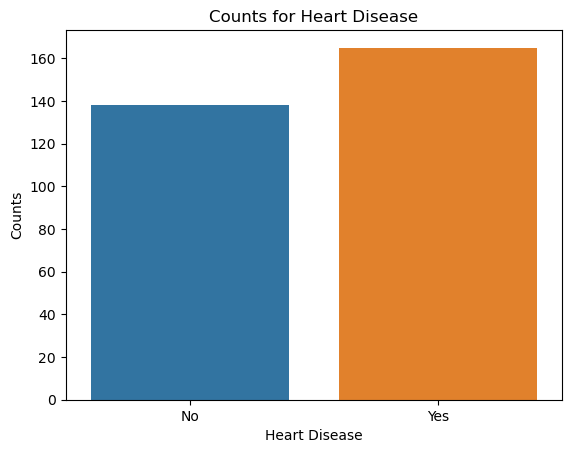

In [12]:
sns.countplot(data = heart, x = "output")
plt.title("Counts for Heart Disease")
plt.xlabel("Heart Disease")
plt.ylabel("Counts")
plt.xticks(ticks = [0,1], labels = ["No", "Yes"])
plt.savefig("Counts.png", bbox_inches = "tight")
plt.show()

If we said "yes" to every observation. Then we would be correct 54.5% of the time. We need to check and see if our models beat this.

Now we will run 10-fold cross validation on our KNN and Random Forest to get adequate hyperparemeters.

### Standardize the data and Look for good parameters for KNN and Random Forest

In [13]:
X = heart.iloc[:,:-1]
y = heart.iloc[:,-1]
kf = KFold(n_splits = 10, shuffle = True, random_state = 10)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [15]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
accuracy = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    cv_score = cross_val_score(knn, x_train_scaled, y_train, cv = kf)
    accuracy.append(cv_score.mean())

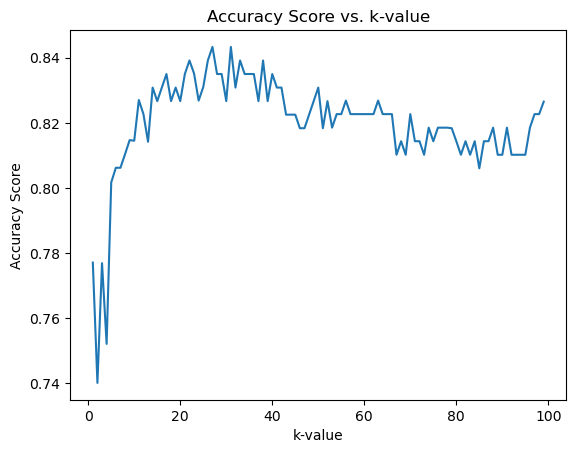

In [17]:
plt.plot(np.arange(1,100), accuracy)
plt.xlabel("k-value")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs. k-value")
plt.savefig("CVKNN.png", bbox_inches = "tight")
plt.show()

We will use a k-value of 20, since this roughly maximizes our accuracy score.

In [20]:
forest = RandomForestClassifier(random_state = 10)
parameters = {'max_depth':np.arange(1,20), 'n_estimators':np.arange(5,70,5), 'max_features':np.arange(1,10,2)}
rf = RandomizedSearchCV(forest, parameters, cv = kf, n_iter = 30).fit(x_train,y_train)

In [21]:
rf.best_params_

{'n_estimators': 50, 'max_features': 7, 'max_depth': 5}

Max_depth of 5 and n_estimators of 50 and max_features of 7

We will now train our models

# KNN

In [22]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(x_train_scaled, y_train)

pred = knn.predict(x_test_scaled)
y_score = knn.predict_proba(x_test_scaled)[:,1]
score_k = accuracy_score(y_test, pred)
cm_k = confusion_matrix(y_test, pred)
fpr_k, tpr_k, _ = roc_curve(y_test, y_score)
auc_k = round(roc_auc_score(y_test, y_score),3)

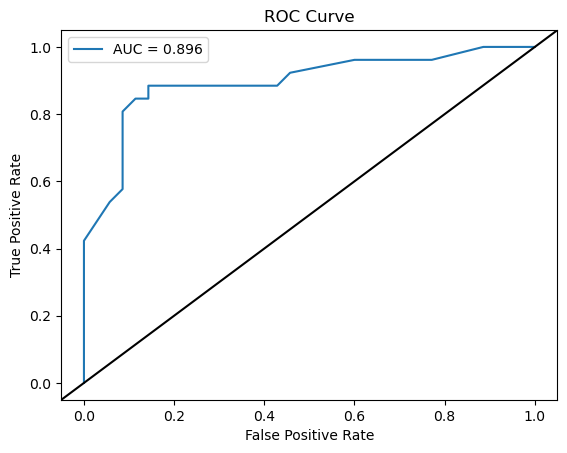

In [23]:
plt.plot(fpr_k, tpr_k, label = "AUC = " + str(auc_k))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

0.8688524590163934


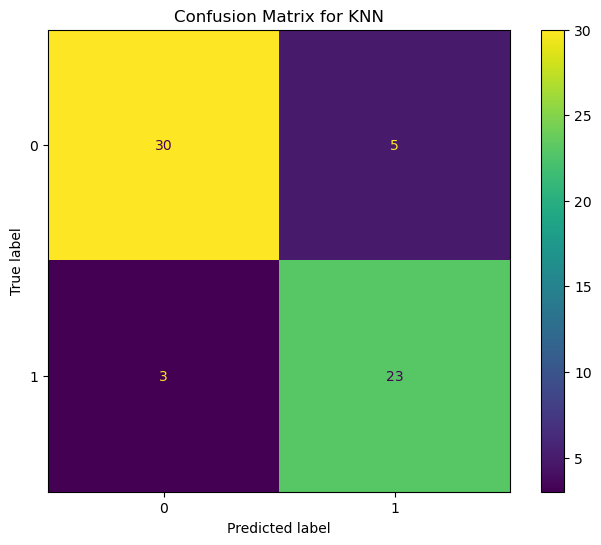

In [24]:
print(score_k)
fig, ax = plt.subplots(figsize = (8,6), dpi = 100)
display = ConfusionMatrixDisplay(cm_k, display_labels = knn.classes_)
ax.set(title = "Confusion Matrix for KNN")
display.plot(ax = ax)

In [25]:
true_neg, false_pos, false_neg, true_pos = cm_k.ravel()
true_neg, false_neg, false_pos, true_pos

(30, 3, 5, 23)

In [26]:
sensitivity = true_pos/(true_pos + false_neg)
precision = true_pos/(true_pos + false_pos)

print(round(sensitivity,2))
print(round(precision,2))

0.88
0.82


In [27]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88        35
           1       0.82      0.88      0.85        26

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# Random Forest

In [28]:
forest = RandomForestClassifier(max_depth = 5, n_estimators = 50, max_features = 7, random_state = 10)
forest.fit(x_train, y_train)

pred = forest.predict(x_test)
y_score = forest.predict_proba(x_test)[:,1]
score_t = accuracy_score(y_test, pred)
cm_t = confusion_matrix(y_test, pred)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score)
auc_rf = round(roc_auc_score(y_test, y_score),3)

### Feature Importance

In [29]:
df_dic = {"name":[], "importance":[]}
name = heart.columns
for name, importance in zip(heart[name], forest.feature_importances_):
    print(name, "=", importance)
    df_dic["name"].append(name) 
    df_dic["importance"].append(importance)

age = 0.05810985728359485
sex = 0.02823015909881779
trtbps = 0.04935711317023243
chol = 0.052488849797852566
fbs = 0.00544435894819581
thalachh = 0.1054327632755372
exng = 0.04825232062597749
oldpeak = 0.09403464247350192
caa = 0.1818382767254264
TA = 0.12477075081251067
ATA = 0.004313290432871264
NAP = 0.023540056194978207
ASY = 0.010236848009866786
Normal = 0.00831809314627911
STT_ab = 0.01062515739367378
hyper = 0.0004422258454269096
up = 0.0032564639499156013
flat = 0.02314254409531853
down = 0.026045219310544102
normal = 0.003197784935067936
FD = 0.10091397003622453
RD = 0.03800925443818587


In [30]:
df_dic
df = pd.DataFrame.from_dict(df_dic)
df = df.sort_values(by = "importance", ascending = False).reset_index(drop = True)

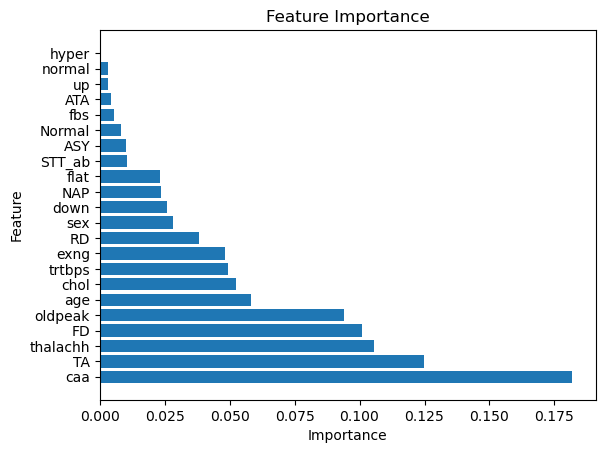

In [31]:
plt.barh(df["name"], df["importance"])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("Importance.png", bbox_inches = "tight")
plt.show()

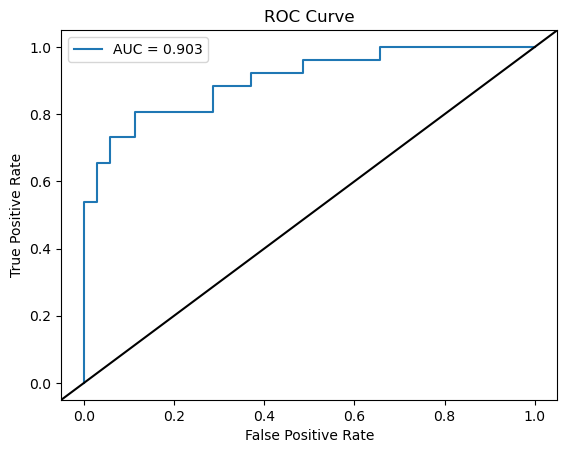

In [32]:
plt.plot(fpr_rf, tpr_rf, label = "AUC = " + str(auc_rf))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

0.8032786885245902


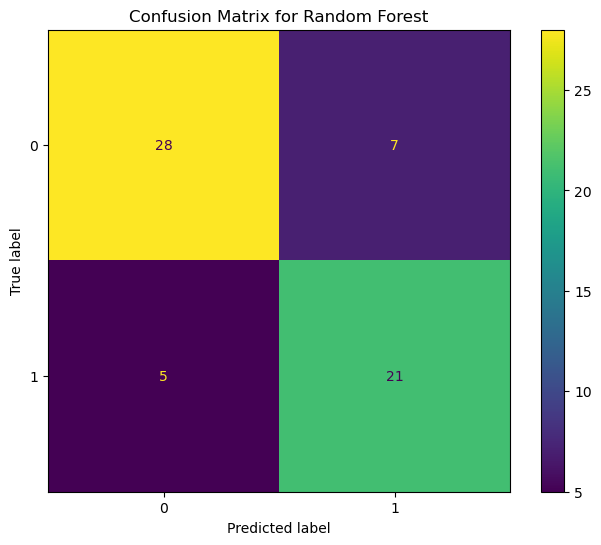

In [33]:
print(score_t)
fig, ax = plt.subplots(figsize = (8,6), dpi = 100)
display = ConfusionMatrixDisplay(cm_t, display_labels = forest.classes_)
ax.set(title = "Confusion Matrix for Random Forest")
display.plot(ax = ax)

In [34]:
true_neg, false_pos, false_neg, true_pos = cm_t.ravel()
true_neg, false_neg, false_pos, true_pos

(28, 5, 7, 21)

In [35]:
sensitivity = true_pos/(true_pos + false_neg)
precision = true_pos/(true_pos + false_pos)

print(round(sensitivity,2))
print(round(precision,2))

0.81
0.75


In [36]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.75      0.81      0.78        26

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



# Logistic Regression

In [37]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(x_train,y_train)

LogisticRegression(max_iter=5000)

In [38]:
pred = log_reg.predict(x_test)
y_score = log_reg.predict_proba(x_test)[:,1]
score_lr_1 = accuracy_score(y_test, pred)
cm_lr_1 = confusion_matrix(y_test, pred)
fpr_lr_1, tpr_lr_1, _ = roc_curve(y_test, y_score)
auc_lr_1 = round(roc_auc_score(y_test, y_score),3)

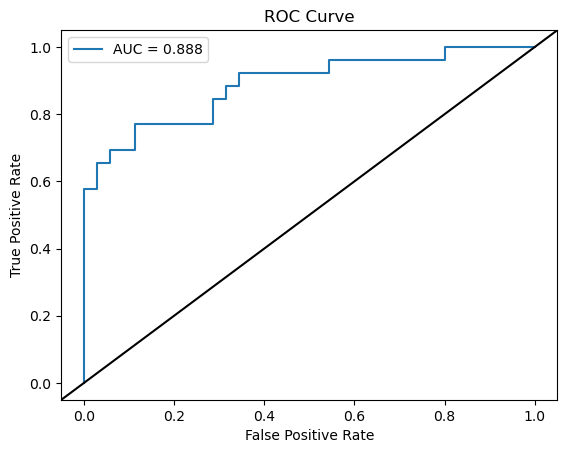

In [39]:
plt.plot(fpr_lr_1, tpr_lr_1, label = "AUC = " + str(auc_lr_1))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

0.7868852459016393


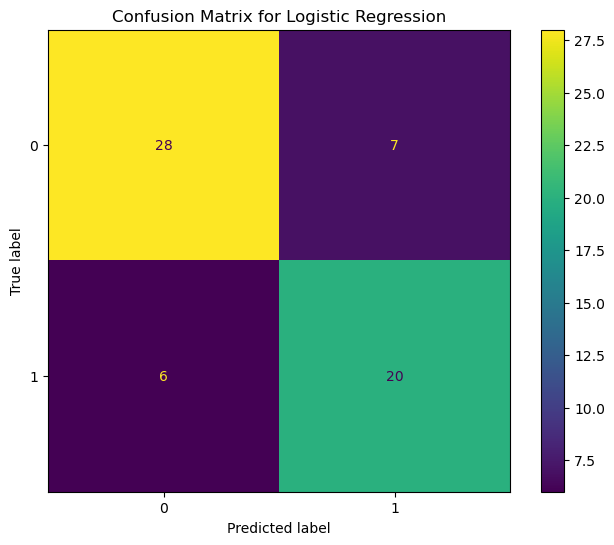

In [40]:
print(score_lr_1)
fig, ax = plt.subplots(figsize = (8,6), dpi = 100)
display = ConfusionMatrixDisplay(cm_lr_1, display_labels = log_reg.classes_)
ax.set(title = "Confusion Matrix for Logistic Regression")
display.plot(ax = ax)

In [41]:
true_neg, false_pos, false_neg, true_pos = cm_lr_1.ravel()
true_neg, false_neg, false_pos, true_pos

(28, 6, 7, 20)

In [42]:
sensitivity = true_pos/(true_pos + false_neg)
precision = true_pos/(true_pos + false_pos)

print(round(sensitivity,2))
print(round(precision,2))

0.77
0.74


In [43]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.74      0.77      0.75        26

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



# Nueral Network

In [44]:
model = Sequential()
model.add(InputLayer(input_shape = (x_train.shape[1],)))
model.add(Dense(8, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [45]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 184       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
es = EarlyStopping(monitor = "val_loss", mode = 'min', verbose = 1, patience = 10)

In [47]:
model.compile(loss = "binary_crossentropy", metrics = ["accuracy"], optimizer = "adam")
model.fit(x_train_scaled, y_train, validation_split = 0.33, epochs = 1000, batch_size = 10, verbose = 1, callbacks = es)

Epoch 1/1000
17/17 [==============================] - 1s 18ms/step - loss: 1.1414 - accuracy: 0.4321 - val_loss: 0.9772 - val_accuracy: 0.4375
Epoch 2/1000
17/17 [==============================] - 0s 5ms/step - loss: 1.0453 - accuracy: 0.4383 - val_loss: 0.9044 - val_accuracy: 0.4375
Epoch 3/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.9650 - accuracy: 0.4691 - val_loss: 0.8429 - val_accuracy: 0.4625
Epoch 4/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.8951 - accuracy: 0.5000 - val_loss: 0.7912 - val_accuracy: 0.5000
Epoch 5/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.8393 - accuracy: 0.5370 - val_loss: 0.7467 - val_accuracy: 0.5250
Epoch 6/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.7889 - accuracy: 0.5432 - val_loss: 0.7099 - val_accuracy: 0.5750
Epoch 7/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.7438 - accuracy: 0.5864 - val_loss: 0.6790 - val_accuracy: 0.6250
Epoch

In [48]:
res_bce, res_acc = model.evaluate(x_test_scaled, y_test, verbose = 0)
print(res_acc)

0.8524590134620667


In [49]:
pred = model.predict(x_test_scaled)
fpr_nn, tpr_nn, _ = roc_curve(y_test, pred)
auc_nn = round(roc_auc_score(y_test, pred),3)
pred = pred > 0.5
cm_nn = confusion_matrix(y_test, pred)
score_nn = accuracy_score(y_test, pred)

2/2 [==============================] - 0s 2ms/step


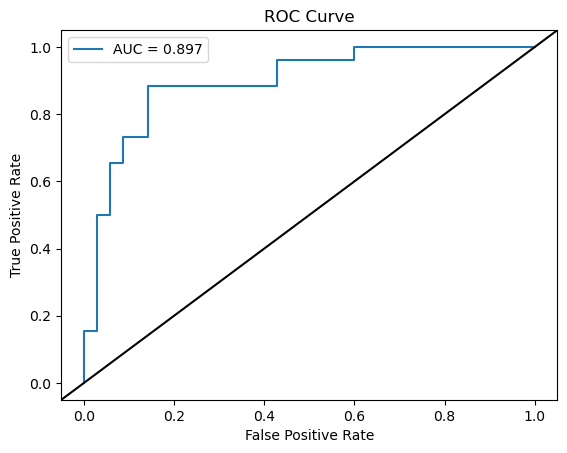

In [50]:
plt.plot(fpr_nn, tpr_nn, label = "AUC = " + str(auc_nn))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

0.8524590163934426


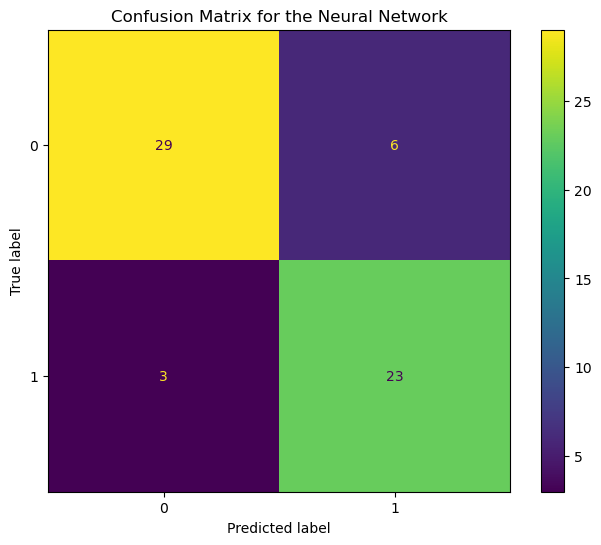

In [51]:
print(score_nn)
fig, ax = plt.subplots(figsize = (8,6), dpi = 100)
display = ConfusionMatrixDisplay(cm_nn)
ax.set(title = "Confusion Matrix for the Neural Network")
display.plot(ax = ax)

In [52]:
true_neg, false_pos, false_neg, true_pos = cm_nn.ravel()
true_neg, false_neg, false_pos, true_pos

(29, 3, 6, 23)

In [53]:
sensitivity = true_pos/(true_pos + false_neg)
precision = true_pos/(true_pos + false_pos)

print(round(sensitivity,2))
print(round(precision,2))

0.88
0.79


In [54]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.79      0.88      0.84        26

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



# Results

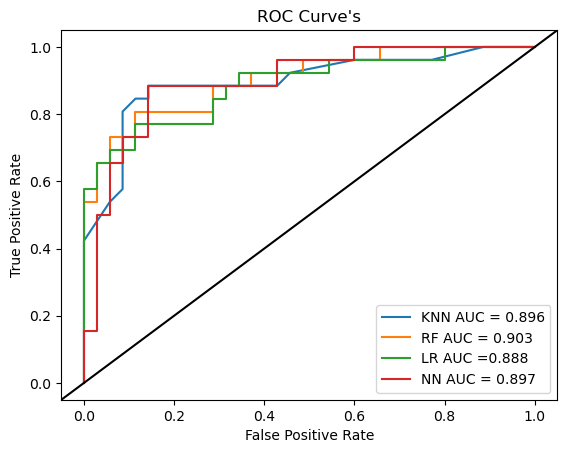

In [55]:
plt.plot(fpr_k, tpr_k,label = "KNN AUC = " + str(auc_k))
plt.plot(fpr_rf, tpr_rf, label = "RF AUC = " + str(auc_rf))
plt.plot(fpr_lr_1, tpr_lr_1, label = "LR AUC =" + str(auc_lr_1))
plt.plot(fpr_nn, tpr_nn, label = "NN AUC = " + str(auc_nn))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve's")
plt.legend()
plt.axline([0,0], [1,1], color = "k")
plt.savefig("ROC.png", bbox_inches = "tight")
plt.show()

In [56]:
print("KNN Accuracy Score: " + str(round(score_k,4)))
print("Random Forest Accuracy Score: " + str(round(score_t,4)))
print("Logistic Regression Accuracy Score: " + str(round(score_lr_1,4)))
print("Neural Network Accuracy Score: " + str(round(score_nn,4)))

KNN Accuracy Score: 0.8689
Random Forest Accuracy Score: 0.8033
Logistic Regression Accuracy Score: 0.7869
Neural Network Accuracy Score: 0.8525
